# DA5401 - A8 Ensemble Learning for Complex Regression Modeling on Bike Share Data

### Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.utils import resample

## Part A: Data Preprocessing and Baseline

### Data Loading and Feature Engineering:

In [ ]:
df = pd.read_csv("hour.csv")

df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

X = df.drop(columns=['cnt'])
y = df['cnt']


In [24]:
X.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

In [25]:
y.isnull().sum()

0

In [ ]:
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), categorical_features)],
    remainder='passthrough'+
)

### Train/Test Split:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model:

In [4]:
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=6, random_state=42))
])
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_rmse = sqrt(mean_squared_error(y_test, dt_pred))

lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = sqrt(mean_squared_error(y_test, lr_pred))

print(f"Decision Tree RMSE: {dt_rmse:.3f}")
print(f"Linear Regression RMSE: {lr_rmse:.3f}")

baseline_rmse = min(dt_rmse, lr_rmse)
baseline_model = "Decision Tree" if dt_rmse < lr_rmse else "Linear Regression"
print(f"\n Baseline Model: {baseline_model} | RMSE = {baseline_rmse:.3f}")

Decision Tree RMSE: 118.456
Linear Regression RMSE: 100.446

 Baseline Model: Linear Regression | RMSE = 100.446


#### Key Insight
The Linear Regression model provides a good initial baseline but may underfit due to its linear assumptions.  


## Part B: Ensemble Techniques for Bias and Variance Reduction

### Bagging (Variance Reduction):

#### Hypothesis: Bagging primarily targets variance reduction.

In [20]:
base_tree = DecisionTreeRegressor(max_depth=6, random_state=42)

bag_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=base_tree,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'model__n_estimators': [30, 50, 100]
}

grid_search = GridSearchCV(
    estimator=bag_pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_bag_model = grid_search.best_estimator_
bag_pred = best_bag_model.predict(X_test)
bag_rmse = sqrt(mean_squared_error(y_test, bag_pred))
print(f"Test RMSE (Best Bagging Model): {bag_rmse:.3f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'model__n_estimators': 100}
Best CV RMSE: 115.75645708068889
Test RMSE (Best Bagging Model): 112.265


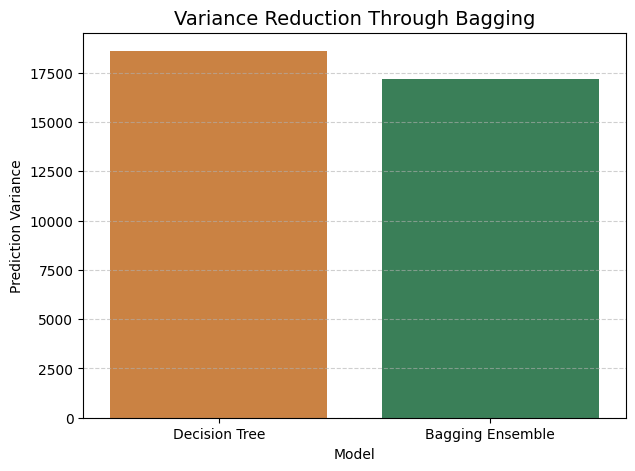

Variance (Decision Tree): 18598.0059
Variance (Bagging Ensemble): 17173.0623


In [29]:
tree_pred = dt_model.predict(X_test)
bag_pred = best_bag_model.predict(X_test)

var_tree = np.var(tree_pred)
var_bag = np.var(bag_pred)

var_data = pd.DataFrame({
    'Model': ['Decision Tree', 'Bagging Ensemble'],
    'Variance': [var_tree, var_bag]
})

plt.figure(figsize=(7,5))
sns.barplot(data=var_data, x='Model', y='Variance', hue='Model',
            palette=['#E1812C', '#2E8B57'], legend=False)
plt.title('Variance Reduction Through Bagging', fontsize=14)
plt.ylabel('Prediction Variance')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print(f"Variance (Decision Tree): {var_tree:.4f}")
print(f"Variance (Bagging Ensemble): {var_bag:.4f}")


### Boosting (Bias Reduction):

#### Hypothesis: Boosting primarily targets bias reduction.

In [21]:
boost_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 4, 5, 6]
}

grid_search_boost = GridSearchCV(
    estimator=boost_pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_boost.fit(X_train, y_train)

print("Best Parameters:", grid_search_boost.best_params_)
print("Best CV RMSE:", -grid_search_boost.best_score_)

best_boost_model = grid_search_boost.best_estimator_
boost_pred = best_boost_model.predict(X_test)
boost_rmse = sqrt(mean_squared_error(y_test, boost_pred))
print(f"Test RMSE (Best Gradient Boosting Model): {boost_rmse:.3f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 300}
Best CV RMSE: 49.874526244555575
Test RMSE (Best Gradient Boosting Model): 48.151


**Observation:**  
Gradient Boosting achieved a significantly lower RMSE than both Bagging and the baseline models.  
This supports the hypothesis that boosting primarily targets bias reduction, producing a strong model by sequentially improving over prior weak learners.


## Part C: Stacking for Optimal Performance

### Stacking Implementation and RMSE:

#### 1. Principle of Stacking
**Stacking** is an advanced ensemble technique that combines predictions from multiple diverse base learners (Level-0 models) using a Meta-Learner (Level-1 model) to achieve optimal predictive performance.

- **Level-0 (Base Learners):**  
  Multiple models (e.g., KNN, Bagging, Gradient Boosting) are trained independently on the training data.  
  Each model learns different data patterns — linear, non-linear, or local — providing diverse prediction perspectives.

- **Level-1 (Meta-Learner):**  
  The meta-learner (here, Ridge Regression) takes the predicted outputs from all base learners as input features and learns how to best combine them.  
  It does so by minimizing the overall prediction error (e.g., RMSE) during training — assigning optimal weights to each base model’s predictions.  
  In essence, models that perform better on certain data regions receive higher influence in the final prediction.

- **Core Idea:**  
  By learning from the strengths and weaknesses of each base learner, the meta-learner produces a weighted ensemble prediction that generalizes better than any single model, effectively balancing bias and variance.


In [22]:
base_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('bag', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=100,
        random_state=42)),
    ('boost', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.2,
        max_depth=6,
        random_state=42))
]

meta_learner = Ridge(alpha=1.0)

stack_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        n_jobs=-1))
])

stack_model.fit(X_train, y_train)
stack_pred = stack_model.predict(X_test)
stack_rmse = sqrt(mean_squared_error(y_test, stack_pred))
print(f"Stacking RMSE: {stack_rmse:.3f}")

Stacking RMSE: 47.769


**Observation:**  
Stacking achieved the lowest RMSE (47.77) among all models.  
This demonstrates that by combining diverse learners, stacking successfully balances bias and variance, outperforming individual ensemble methods.

**Key Takeaway:**
The meta-learner (Ridge Regression) effectively learned how to weight predictions from KNN, Bagging, and Gradient Boosting to minimize error, confirming that model diversity is crucial for ensemble success.

## Part D: Final Analysis


 Model Performance Comparison:


,Model,RMSE
0,Baseline (Linear Regression),100.445946
1,Bagging,112.265023
2,Gradient Boosting,48.150810
3,Stacking,47.769156


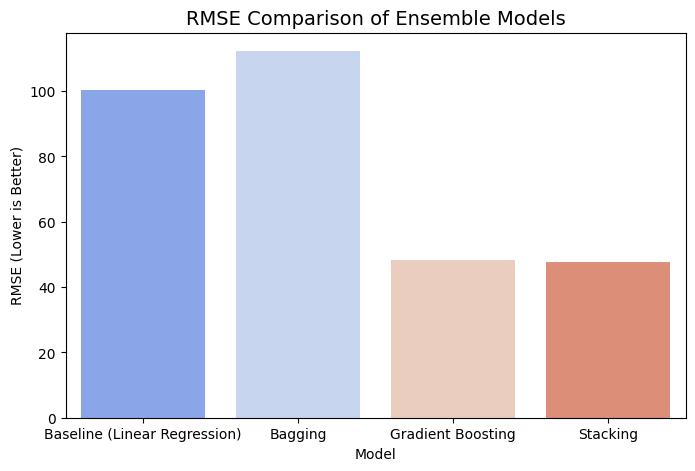

Best Model: Stacking | RMSE = 47.769


In [23]:
results = pd.DataFrame({
    'Model': ['Baseline (' + baseline_model + ')', 'Bagging', 'Gradient Boosting', 'Stacking'],
    'RMSE': [baseline_rmse, bag_rmse, boost_rmse, stack_rmse]
})

print("\n Model Performance Comparison:")
display(results)

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='RMSE', data=results, palette='coolwarm', hue='Model')
plt.title('RMSE Comparison of Ensemble Models', fontsize=14)
plt.ylabel('RMSE (Lower is Better)')
plt.show()

best_model = results.loc[results['RMSE'].idxmin()]
print(f"Best Model: {best_model['Model']} | RMSE = {best_model['RMSE']:.3f}")


#### Discussion and Conclusion

- **Best Model:**  Stacking Regressor (RMSE = 47.77)  
- **Performance Order:** Stacking > Gradient Boosting > Linear Regression > Bagging > Decision Tree

**Explanation (Bias–Variance Perspective):**
- Linear Regression → High bias, low variance → underfits.
- Decision Tree → Low bias, high variance → overfits.
- Bagging → Reduces variance of trees via averaging → more stable predictions.
- Boosting → Reduces bias via sequential corrections → strong generalization.
- Stacking → Combines diverse models → balances both bias and variance optimally.
---
#### Final Insight
The **Stacking Regressor** achieved the best performance because it integrates model diversity:
- KNN captures local similarity.
- Bagging stabilizes high-variance predictions.
- Gradient Boosting improves weak learners iteratively.
- Ridge Regression meta-learner blends them optimally.

This synergy leverages the **bias-variance trade-off**, yielding the most robust and accurate predictive model for bike rental forecasting.
